In [1]:
%env MISTRAL_API_KEY=ZL4LdkeCwsoIYcNx2aFDujTYgpwj2kij
import os
import base64
import matplotlib.pyplot as plt
from mistralai import Mistral
import json
import pandas as pd
from typing import Union
import numpy as np
import secrets

pd.set_option('display.max_colwidth', None)
# Load Mistral API key from environment variables
api_key = os.environ["MISTRAL_API_KEY"]

# Initialize the Mistral client
client = Mistral(api_key=api_key)

env: MISTRAL_API_KEY=ZL4LdkeCwsoIYcNx2aFDujTYgpwj2kij


In [2]:
def img_to_base64(image_path):
    """Input : image_path (str) : path to the image file
    Returns : image_base64 (str) : base64 encoded image"""
    
    with open(image_path, 'rb') as image_file:
        image_bytes = image_file.read()

    image_base64 = base64.b64encode(image_bytes).decode('utf-8')
    
    return image_base64

def json_to_dataframe(json_data: Union[str, dict], key: str = None) -> pd.DataFrame:
    # If json_data is a string, parse it into a dictionary
    if isinstance(json_data, str):
        json_data = json.loads(json_data)
    
    # If a key is provided, extract the list of records from the JSON object
    if key is not None:
        data = json_data[key]
    else:
        data = json_data
    
    # Convert the list of records to a pandas DataFrame
    df = pd.DataFrame(data)
    
    return df

def list_clothes(args): 
    image_base64, guide = args
    # Define the messages for the chat API
    messages = [
        {
            "role": "system",
            "content": "Return the answer in a JSON object with the next structure: "
                    "{\"elements\": [{\"element\": \"some name for element1\", "
                    "\"color\": \"the color of element1\", "
                    "\"fit\": \"the fit, shape of element1.\", "
                    "\"price\": \"some number, estimated price of element1\", "
                    "\"context\": \"a word describing the occasion, mood or functionality of the piece\", "
                    "\"description\": \"a description of element1, emphasizing on the vibe of the piece and that encapsulates the precedent variables\"}, "
                    "{\"element\": \"some name for element2\", ...}]}"
        },
        {
            "role": "system",
            "content": f"You are a fashion critique, neutral and objective.\n\n {guide} \n\n You are presented with an image of an outfit, describe each of the elements thanks to your expertise "
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": f"data:image/jpeg;base64,{image_base64}"
                }
            ]
        }
    ]

    # Call the Mistral API to complete the chat
    chat_response = client.chat.complete(
        model="pixtral-12b-2409",
        messages=messages,
        temperature=0.4,
        response_format={
            "type": "json_object",
        }
    )

    # Get the content of the response
    content = chat_response.choices[0].message.content
    
    return content

def process_critique(args):
    outfit, guide = args
    
    chat_response = client.chat.complete(
        model="mistral-large-latest",
        messages=[
            {"role": "system", "content": "As a 'Fashion Critique', your mission is to help relook people. \n\n {guide} \n\n You are given a description of items in an outfit. Give a critique of the outfit, outlining the general vibe, how the pieces work together and what could be improved."},
            {"role": "user", "content": outfit},
        ],
        temperature=0.2,
        max_tokens=2048
    )
    result = chat_response.choices[0].message.content

    return result

def recommend_item(critique, guide, color_rule, piece_rule): 
    # Define the messages for the chat API
    messages = [
        {
            "role": "system",
            "content": "Return the answer in a JSON object with the next structure: "
                    "{\"elements\": [{\"element\": \"some short name for element1\", "
                    "\"color\": \"the color of element1\", "
                    "\"fit\": \"the fit, shape of element1. Be concise.\", "
                    "\"price\": \"some number, estimated price of element1\", "
                    "\"context\": \"a word describing the occasion, mood or functionality of the piece\", "
                    "\"description\": \"a description of element1, emphasizing on the vibe of the piece and that encapsulates the precedent variables\"}]}"
        },
        {
            "role": "system",
            "content": f"You are a fashion critique, neutral and objective.\n\n {guide} \n\n You are presented with a critique of an outfit, describe a single element that would improve the outfit."
        },
        {
            "role": "system",
            "content": "Follow this rule when suggesting a piece of clothing: " + piece_rule
        },
        {
            "role": "system",
            "content": "Follow this rule when choosing a color: " + color_rule
        },
        {
            "role": "user",
            "content": critique
        }
    ]

    # Call the Mistral API to complete the chat
    chat_response = client.chat.complete(
        model="mistral-large-latest",
        messages=messages,
        temperature=0.4,
        response_format={
            "type": "json_object",
        }
    )

    # Get the content of the response
    content = chat_response.choices[0].message.content
    
    return content

def save_df(clothes_df, reco_df):
    random_hash = secrets.token_hex(4)
    clothes_df.to_pickle(f"./data/clothes_{random_hash}.pkl")
    reco_df.to_pickle(f"./data/reco_{random_hash}.pkl")

def load_df(hash):
    clothes_df = pd.read_pickle(f"./data/clothes_{hash}.pkl")
    reco_df = pd.read_pickle(f"./data/reco_{hash}.pkl")
    
    return clothes_df, reco_df

In [3]:
desc_guide_path = "../desc_guide.txt"
critique_guide_path = "../critique_guide.txt"

with open(critique_guide_path, "rb") as f:
    critique_guide = f.read()

with open(desc_guide_path, "r") as f:
    desc_guide = f.read()

,element,color,fit,price,context,description
0,Headphones,Black,"Over-ear, snug fit",Estimated $50-$150,"Casual, everyday use","Black over-ear headphones that provide a sleek, modern look, ideal for casual, everyday use. The snug fit ensures comfort during extended wear."
1,Hoodie,Light Beige,"Oversized, loose fit with drawstrings",Estimated $80-$200,"Casual, laid-back style","A light beige hoodie with an oversized, loose fit and drawstrings for adjustability. The soft fabric offers a cozy feel, perfect for a casual, laid-back style."
2,T-Shirt,White,"Relaxed, slightly oversized",Estimated $20-$50,"Casual, everyday wear","A white t-shirt with a relaxed, slightly oversized fit. The neutral color pairs well with various outfits, making it a versatile choice for casual, everyday wear."
3,Jeans,Light Green,"Baggy, wide-leg with a relaxed fit",Estimated $60-$150,"Casual, streetwear style","Light green baggy jeans with a wide-leg and relaxed fit. The unique color adds a pop of freshness to the outfit, perfect for a casual, streetwear style."
4,Sneakers,White with Blue Accents,"Comfortable, sporty design",Estimated $50-$150,"Casual, everyday use","White sneakers with blue accents, featuring a comfortable, sporty design. The minimalist style makes them versatile for various casual outfits."
5,Bag,Olive Green,"Small, structured design",Estimated $30-$100,"Casual, everyday use","An olive green bag with a small, structured design. The practical size and color make it a versatile accessory for casual, everyday use."


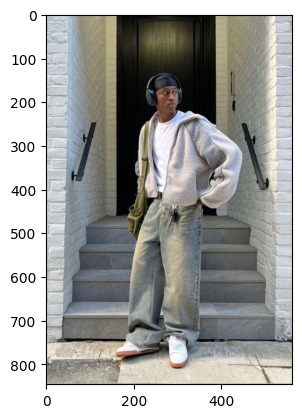

In [4]:
img_path = f"../test_images/img1.jpg"
plt.imshow(plt.imread(img_path))

img_64 = img_to_base64(img_path)
clothes = list_clothes((img_64, desc_guide))
clothes_df = json_to_dataframe(clothes, key='elements')
clothes_df

In [6]:
outfit = '-'+'\n-'.join(clothes_df['description'])
critique = process_critique((outfit, critique_guide))
print(critique)

**Outfit Critique**

**General Vibe:** The outfit exudes a casual, streetwear vibe with a mix of neutral and fresh colors. It's well-suited for a relaxed, everyday look, combining comfort and style.

**What Works:**

1. **Color Palette:** The neutral colors of the hoodie, t-shirt, and sneakers are nicely complemented by the light green jeans and olive green bag. This creates a harmonious and balanced look.

2. **Fit and Silhouette:** The oversized hoodie and baggy jeans create a relaxed silhouette, which is consistent with the casual streetwear aesthetic.

3. **Versatility:** Each piece is versatile and can be easily mixed and matched with other items in a wardrobe.

**What Could Be Improved:**

1. **Proportion:** While the oversized fit is intentional, ensure that the hoodie and jeans are not so oversized that they overwhelm your frame. Consider balancing the proportions, perhaps by opting for a slightly more fitted hoodie or adjusting the drawstrings for a better fit.

2. **Accessori

In [ ]:
reco_df=[]
n_suggest = 3
color_rules = np.random.choice([ 
                          "complementary colors: colors that are opposite on the color wheel", 
                          "analogus colors: colors that are close on the color wheel", 
                          "accent color: one bright color that pops from the rest that are neutral", 
                          "sandwiching: layering a bright color between two neutral colors",
                          "monochromatic: using different shades of the same color to create a cohesive look",
                          "pattern mixing: combining different patterns to create a unique outfit",
                          "seasonal: using seasonal colors and pieces to create a weather-appropriate outfit",
                                    ], n_suggest, replace=False)
    
piece_rules = np.random.choice([
                           "mixing textures: incorporating different textures to add visual interest",
                                "statement piece: building an outfit around a bold statement piece",
                                "proportion balance: suggest a piece with a fit that balances the outfit", 
                                "accessories: adding an accessory to elevate the outfit",
                                "silouhette: creating a visually interesting shape with the outfit",
                                "replacement: suggesting a piece that would replace a current piece in the outfit",
                                "layering: adding a layer to the outfit to create depth, like a coat or jacket",
                                "adding surface: suggest a pig piece with a different surface, like a shiny or matte fabric"
                                   ], n_suggest, replace=False)
for i in range(n_suggest):
    reco = recommend_item(critique, desc_guide, color_rules[i], piece_rules[i])  
    reco_df.append(json_to_dataframe(reco, key='elements'))

reco_df = pd.concat(reco_df,ignore_index=True)
reco_df

,element,color,fit,price,context,description
0,Bomber Jacket,Bright Orange,"Regular, falls at the hip. Ribbed collar, cuffs and hem for structure.",120,casual autumn,"A vibrant orange bomber jacket crafted from lustrous satin, featuring a ribbed collar, cuffs, and hem for a secure and comfortable fit. This jacket follows the 'sandwiching' color rule, creating a visually appealing layered look when worn with neutral pieces from the critiqued outfit. It adds a pop of color and enhances the overall silhouette, making the outfit more dynamic and interesting. Perfect for adding a touch of bold style to a casual autumn look."
1,Red Beanie,Red,"Snug, ribbed fit.",15,Casual,"A vibrant red beanie with a snug, ribbed fit that adds a pop of color to the neutral tones of the outfit. This accessory not only elevates the look with its bold accent color but also complements the casual, streetwear vibe. Perfect for adding a touch of personal style and warmth on cooler days."
2,Corduroy Jacket,Burgundy,"Slightly fitted, with a structured collar.",80,Casual,"A burgundy corduroy jacket with a slightly fitted silhouette and a structured collar, offering a complementary pop of color and adding textural interest to the outfit with its ribbed fabric. Perfect for layering over the hoodie to create a more dynamic and refined casual look."


In [17]:
save_df(clothes_df, reco_df)

In [16]:
clothes_df, reco_df = load_df("40ef0440")
reco_df


FileNotFoundError: [Errno 2] No such file or directory: './data/clothes_40ef0440.pkl'